In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from hawkes.hawkes import hawkes, hawkes_calculate, sampleHawkes, plotHawkes, iterative_sampling, extract_samples, sample_counterfactual_superposition, check_monotonicity_hawkes
from sampling_utils import thinning_T, return_samples
from counterfactual_tpp import sample_counterfactual, check_monotonicity, distance, covariance
from multiprocessing import cpu_count, Pool
from tqdm import tqdm
import utils

In [2]:
def sample_counterfactual_superposition_plot(mu0, alpha, new_mu0, new_alpha, all_events, lambda_max, w, T):
    """Generates samples from the counterfactual intensity, and return the counterfactuals.
    This is done in 3 steps:
        1. First we calculate the counterfactual basedon the history in each exponential (created by superposiiton.).
        2. Then we determine the events that were rejected in original intensity and accepted in intevened intensity (rej_acc).
        3. Then we create a new exponential and sample for each rej_acc event.
    """
    def constant1(x): return mu0
    def constant2(x): return new_mu0
    all_counterfactuals = {}
    all_counterfactuals['mu'] = []
    all_counterfactuals['exp'] = []
    all_counterfactuals['new'] = []
    count = 0
    counterfactuals = {}
    for t_i, events in all_events.items():
        sample = list(events.keys())
        if count == 0:
            lambdas = [constant1(s) for s in sample]
            counterfactuals_events, counterfactual_indicators = sample_counterfactual(
                sample, lambdas, lambda_max, list(events.values()), constant2)
            all_counterfactuals['mu'].extend(counterfactuals_events)
        else:
            def f(t): return alpha * np.exp(-w * (t - t_i))
            def g(t): return new_alpha * np.exp(-w * (t - t_i))
            lambdas = [f(s) for s in sample]
            counterfactuals_events, counterfactual_indicators = sample_counterfactual(
                sample, lambdas, lambda_max, list(events.values()), g)
            all_counterfactuals['exp'].extend(counterfactuals_events)
        count += 1
        counterfactuals.update(
            {sample[s]: counterfactual_indicators[s] for s in range(len(sample))})

    rej_acc_events = {}
    for events in list(all_events.values()):
        for t_i in list(events.keys()):
            if events[t_i] == False and counterfactuals[t_i] == True:
                rej_acc_events[t_i] = True

    new_events = {}
    iterative_sampling(new_events, rej_acc_events, new_mu0,
                       new_alpha, w, lambda_max, T)
    # These are the additional counterfactuals sampled from the new intensity.
    sampled_counterfactuals = list(new_events.keys())
    sampled_counterfactuals.sort()
    all_counterfactuals['new'].extend(sampled_counterfactuals)

    # Combine all counterfactuals
    real_counterfactuals = [k for k, v in counterfactuals.items() if v == True]
    real_counterfactuals.extend(sampled_counterfactuals)
    real_counterfactuals.sort()
    real_counterfactuals = list(dict.fromkeys(real_counterfactuals))
    return real_counterfactuals, all_counterfactuals

In [3]:
def plotHawkes_plot(tevs, l_0, alpha_0, w, T, resolution, label, legend):

    tvec = np.arange(0, T, step=T / resolution)

    n = -1
    l_t = np.zeros(len(tvec))
    for t in tvec:
        n += 1
        m = l_0(t)
        l_t[n] = m + alpha_0 * np.sum(np.exp(-w * (t - tevs[tevs < t])))

    plt.plot(tvec, l_t, label=label)

    return tvec, l_t

In [4]:
def check_monotonicity_hawkes(mu0, alpha, new_mu0, new_alpha, all_events, sampled_events, real_counterfactuals, w):
    count = 0
    monotonic = 1
    def constant1(x): return mu0
    def constant2(x): return new_mu0
    for t_i, events in all_events.items():
        sample = list(events.keys())
        if count == 0:
            for s in sample: 
                if constant2(s) >= constant1(s) and s in sampled_events:
                    if s not in real_counterfactuals:
                        return('NOT  MONOTONIC, 1')
                        monotonic = 0
                if constant2(s) < constant1(s) and s not in sampled_events:
                    if s in real_counterfactuals:
                        return('NOT  MONOTONIC, 2')
                        monotonic = 0
        else:
            for s in sample:
                def f(t): return alpha * np.exp(-w * (t - t_i))
                def g(t): return new_alpha * np.exp(-w * (t - t_i))
                if g(s) >= f(s) and s in sampled_events:
                    if s not in real_counterfactuals:
                        return('NOT  MONOTONIC, 3')
                        monotonic = 0
                if g(s) < f(s) and s not in sampled_events:
                    if s in real_counterfactuals:
                        return('NOT  MONOTONIC, 4')
                        monotonic = 0
        count += 1
        
    if monotonic == 1:
            return('MONOTONIC')

In [5]:
np.random.seed(5)
w = 1
mu0 = 1
new_mu0 = 1
alpha = 1

In [6]:
new_alpha = alpha + np.random.normal(loc=0.0, scale=1, size=1)[0]
print(new_alpha)

1.4412274868850414


In [7]:
lambda_max = 1.5
T = 5

In [8]:
def counterfactual1(_):
    initial_sample, indicators = thinning_T(0, lambda t: mu0, lambda_max, T)
    events = {initial_sample[i]: indicators[i] for i in range(len(initial_sample))}
    all_events = {}
    all_events[mu0] = events
    iterative_sampling(all_events, events, mu0, alpha, w, lambda_max, T)
    sampled_events = list(all_events.keys())[1:]
    sampled_events.sort()
    sampled_events = np.array(sampled_events)
    counters = []
    for counter in range(50):
        real_counterfactuals = sample_counterfactual_superposition(mu0, alpha, new_mu0, new_alpha, all_events, lambda_max, w, T)
        counters.append(real_counterfactuals)
    return sampled_events, counters, all_events

In [9]:
# Read
import json
with open(r'data_hawkes/allevents.json', "r") as read_file:
    data = json.load(read_file)

In [10]:
new_data = []
for dic in data:
    new_dic = {}
    for key, value in dic.items():
        sub_dic = {}
        for k, v in value.items():
            sub_dic[float(k)] = v
        new_dic[float(key)] = sub_dic
    new_data.append(new_dic)

In [11]:
def counterfactual2(_):
    all_events = new_data[_]
    counters = []
    all_counters = []
    for counter in range(100):
        real_counterfactuals, all_counterfactuals = sample_counterfactual_superposition_plot(mu0, alpha, new_mu0, new_alpha, all_events, lambda_max, w, T)
        counters.append(real_counterfactuals)
        all_counters.append(all_counterfactuals)
        sampled_events = list(all_events.keys())[1:]
        sampled_events.sort()
        sampled_events = np.array(sampled_events)
        if check_monotonicity_hawkes(mu0, alpha, new_mu0, new_alpha, all_events, sampled_events, real_counterfactuals, w) != 'MONOTONIC':
            print('Not Monotonic')
    return all_events, counters, all_counters

In [5]:
with Pool(48) as pool:
    result = list(tqdm(pool.imap(counterfactual1, list(range(1000))), total = 1000))

100%|██████████| 1000/1000 [06:24<00:00,  2.60it/s]


In [12]:
with Pool(48) as pool:
    result = list(tqdm(pool.imap(counterfactual2, list(range(1000))), total = 1000))

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:48<00:00,  5.93it/s]


In [6]:
# Save
# all_events_save = [result[i][2] for i in range(1000)]
# import json
# # json.dump(all_events, output_file)
# with open('data_hawkes/allevents.json', 'w') as fout:
#     json.dump(all_events_save , fout)

In [ ]:
# save = [result[i][0] for i in range(1000)]
# np.save('data_hawkes/hawkes_1000_100.npy', save, allow_pickle=True)

In [13]:
b = np.load('data_hawkes/hawkes_1000_100.npy', allow_pickle=True)

In [14]:
def count_interval(start, end, samples):
    return len(samples[(start <= samples) & (samples < end)])

In [15]:
number_of_events = [count_interval(0, T, b[i]) for i in range(len(b))]
len(number_of_events)

1000

In [16]:
number_of_groups = 3
quantile_indices = pd.qcut(number_of_events, number_of_groups, labels = range(number_of_groups)).to_numpy()
max(number_of_events)

59

In [17]:
groups = [[] for i in range(number_of_groups)]
samples_groups = [[] for i in range(number_of_groups)]
for i in range(1000):
    k = quantile_indices[i]
    groups[k].extend(result[i][1])
    samples_groups[k].append(b[i])
for i in range(number_of_groups):
    print(len(groups[i]) / 100)

364.0
348.0
288.0


In [19]:
plot_groups = [[] for i in range(number_of_groups)]
for i in range(1000):
    k = quantile_indices[i]
    plot_groups[k].append((b[i], result[i][1], result[i][2], result[i][0]))

In [20]:
means = []
for i in range(number_of_groups):
    sum = 0
    for j in range(len(samples_groups[i])):
        sum += len(samples_groups[i][j])
    means.append(sum / len(samples_groups[i]))
means = [ '%.2f' % elem for elem in means ]
print(means)

['5.04', '17.17', '36.17']


In [22]:
print(min(len(samples_groups[0][j]) for j in range(len(samples_groups[0]))), end = ', ')
print(max(len(samples_groups[0][j]) for j in range(len(samples_groups[0]))))
print('******************')
print(min(len(samples_groups[1][j]) for j in range(len(samples_groups[1]))), end = ', ')
print(max(len(samples_groups[1][j]) for j in range(len(samples_groups[1]))))
print('******************')
print(min(len(samples_groups[2][j]) for j in range(len(samples_groups[2]))), end = ', ')
print(max(len(samples_groups[2][j]) for j in range(len(samples_groups[2]))))

0, 9
******************
10, 22
******************
25, 59


In [23]:
d = []
for i in range(number_of_groups):
    for j in range(len(groups[i])):
        d.append([means[i], len(groups[i][j])])
        
df = pd.DataFrame(d, columns=['Group', 'Number of Counterfactuals'])

In [25]:
df.to_csv('data_hawkes/higher_hawkes.csv')

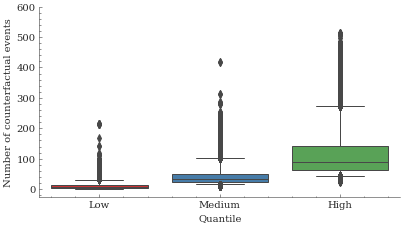

In [26]:
df = pd.read_csv('data_hawkes/higher_hawkes.csv')
width_pt = 397
fig_height, fig_aspect = utils.get_fig_dim(width_pt, fraction=0.65)
fig, ax = plt.subplots(figsize=(4*fig_aspect,3.5))
plt.style.use(['science','no-latex'])
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
sns.boxplot(x="Group", y="Number of Counterfactuals", data=df, palette="Set1", whis=[5, 95]).set(
    xlabel= "Quantile", 
    ylabel= "Number of counterfactual events"
)
sns.despine()
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_yticks(range(0,700,100))
# fig.savefig('hawkes_high.pdf', bbox_inches = 'tight')

In [ ]:
width_pt = 397
fig_height, fig_aspect = utils.get_fig_dim(width_pt, fraction=0.65)
fig, ax = plt.subplots(figsize=(fig_height*5,fig_height/2))
plt.style.use(['science','no-latex'])
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False

In [47]:
# i = 0, j = 0, k = 0
# i = 1, j = 100, k = 20
# i = 2, j = 0, k = 0
# *************************
# i = 0, j = 0, k = 0
# i = 1, j = 0, k = 0
# i = 2, j = 0, k = 0

In [30]:
# you can select j and k randomly
i = 0
k = 0
j = 0 # from 0 to the length of the group
all_events = plot_groups[i][j][3].copy()
mu_events = [k for k, v in all_events[mu0].items() if v == True]
s_plot = plot_groups[i][j][0]
s = np.array(list(set(s_plot) - set(mu_events)))
c = plot_groups[i][j][1][k]
all_c = plot_groups[i][j][2][k].copy()
all_c['new'] = list(set(all_c['new']) - set(all_c['exp']))
# print(s) # sample
# print(mu_events)
# print(c) # counterfactuals
# print(all_c)
# print(len(c))
# print(np.sum([len(v) for v in all_c.values()]))

Text(0.5, 0, 'time')

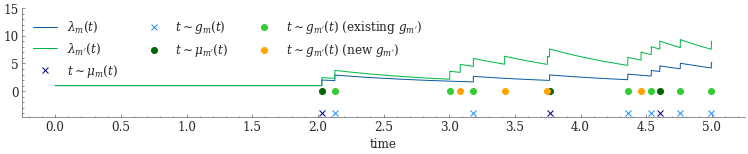

In [33]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.figure(figsize=(8 * fig_aspect,2))
a, b = plotHawkes_plot(s_plot, lambda t: mu0, alpha, w, T, 10000.0, label= r'$\lambda_m(t)$', legend= 'accepted in counterfactual')
a, b = plotHawkes_plot(np.array(c), lambda t: new_mu0, new_alpha, w, T, 10000.0, label= r"$\lambda_{m'}(t)$", legend= 'accepted in counterfactual')
plt.plot(mu_events, [-4 for i in range(len(mu_events))], 'x', color = 'navy',  label = r'$t \sim \mu_m(t)$')
plt.plot(s, [-4 for i in range(len(s))], 'x', color = 'dodgerblue', label = r"$t \sim g_{m}(t)$")
plt.plot(all_c['mu'], [0 for i in range(len(all_c['mu']))], 'o', color = 'darkgreen', label = r"$t \sim \mu_{m'}(t)$")
plt.plot(all_c['exp'], [0 for i in range(len(all_c['exp']))], 'o', color = 'limegreen', label = r"$t \sim g_{m'}(t)$ (existing $g_{m'}$)")
plt.plot(all_c['new'], [0 for i in range(len(all_c['new']))], 'o', color = 'orange', label = r"$t \sim g_{m'}(t)$ (new $g_{m'}$)")
plt.legend(loc='upper left', fontsize = 12, ncol=3)
plt.xticks(np.arange(0,T +0.5,0.5))
plt.yticks(np.arange(0,20,5))
plt.xlabel('time')
# plt.savefig('figs/hawkes_figs/example5box.pdf', bbox_inches = 'tight')